In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(".\properatti.csv", index_col=0)
data.shape

(121220, 25)

In [3]:
# Definimos dos grupos de columas para poder trabajar con ellas de forma mas sencilla
places = ['place_name','place_with_parent_names', 'country_name','state_name']
geolocation = ['geonames_id', 'lat-lon','lat','lon']

# Creamos un nuevo dataframe con las columnas que me interesan
geo_location_data = data[ geolocation].copy()
geo_location_data.head()

,geonames_id,lat-lon,lat,lon
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447


In [4]:
# Vemos que hay valores nulos en las columnas que nos interesan
geo_location_data.isnull().sum()


geonames_id    18717
lat-lon        51550
lat            51550
lon            51550
dtype: int64

### Corroborar si lat-lon coincide con las columnas lat y lon

In [5]:
# Corroboremos que los valores nulos en lat-lon son los mismos que en lat y lon
geo_location_data[geo_location_data['lat-lon'].isnull()]['lat'].isnull().sum() == geo_location_data[geo_location_data['lat-lon'].isnull()]['lon'].isnull().sum()


True

In [6]:
# Dropeamos los valores nulos de lat-lon
geo_location_data.dropna(subset=['lat-lon'], inplace=True)
geo_location_data.isnull().sum()

geonames_id    10532
lat-lon            0
lat                0
lon                0
dtype: int64

In [7]:
# Convertimos la columna lat-lon en dos columnas nuevas
geo_location_data['lat_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[0])
geo_location_data['lon_alt'] = geo_location_data['lat-lon'].apply(lambda x: x.split(',')[1])
geo_location_data.head()


,geonames_id,lat-lon,lat,lon,lat_alt,lon_alt
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,-34.6618237,-58.5088387
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,-34.9038831,-57.9643295
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,-34.6522615,-58.5229825
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,-34.6477969,-58.5164244
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,-38.0026256,-57.5494468


In [8]:
# Vemos los tipos de datos
geo_location_data.dtypes

geonames_id    float64
lat-lon         object
lat            float64
lon            float64
lat_alt         object
lon_alt         object
dtype: object

In [9]:
# convertimos las nuevas columnas a float
geo_location_data['lat_alt'] = geo_location_data['lat_alt'].astype(float)
geo_location_data['lon_alt'] = geo_location_data['lon_alt'].astype(float)
geo_location_data.dtypes

geonames_id    float64
lat-lon         object
lat            float64
lon            float64
lat_alt        float64
lon_alt        float64
dtype: object

In [10]:
# Comprobamos que los valores de las nuevas columnas son iguales a los de las columnas originales
print("Diferencia entre lat:",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum())
print("Diferencia entre lon:",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum())
# En proporción
print("Diferencia en proporción de lat",(geo_location_data['lat_alt'] != geo_location_data['lat']).sum()/ geo_location_data.shape[0])
print("Diferencia en proporción de lon",(geo_location_data['lon_alt'] != geo_location_data['lon']).sum()/ geo_location_data.shape[0])


Diferencia entre lat: 11507
Diferencia entre lon: 14658
Diferencia en proporción de lat 0.16516434620353093
Diferencia en proporción de lon 0.21039184728003446


Hay diferencias en 21% los casos. Veamos si es una diferencia significativa

Revisamos el margen de diferencia redondeando progresivamente.

In [11]:
from decimal import Decimal

In [12]:
Decimal(geo_location_data['lon'][0]).as_tuple().exponent

-46

In [13]:
# Reviso la cantidad de decimales que tienen los valores de lat y lon
geo_location_data['lat'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    33560
-46    16130
-45     7979
-44     4494
-48     3399
-43     2077
-42     1028
-41      564
-40      164
-39      155
-38       55
-37       32
-36       18
-35        5
-7         4
-8         2
 0         2
-34        1
-4         1
Name: lat, dtype: int64

In [14]:
geo_location_data['lon'].apply(lambda x: Decimal(x).as_tuple().exponent).value_counts()

-47    31972
-46    18963
-45     9048
-44     5085
-43     2337
-42     1188
-41      561
-40      213
-39      190
-38       52
-37       28
-36       20
-34        4
-35        3
 0         2
-8         1
-2         1
-32        1
-4         1
Name: lon, dtype: int64

In [15]:
# Vamos redondeando progresivamente los valores de lat y lon
lat_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lat_alt'].round(i) != geo_location_data['lat'].round(i)).sum()/ geo_location_data.shape[0]
    lat_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en latitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)
   
print("////////////////////////////////////")   

lon_decimal_diff = []
for i in range(47,0,-1):
    margin = (geo_location_data['lon_alt'].round(i) != geo_location_data['lon'].round(i)).sum()/ geo_location_data.shape[0]
    lon_decimal_diff.insert(0,margin)
    # print('Margen de diferencia de',i,'decimales en longitud:', margin)
# Buscamos dónde el margen de diferencia es menor al 1%
    if margin <= 0.01:
        print('Margen de diferencia de',i,'decimales en latitud:', margin)




Margen de diferencia de 14 decimales en latitud: 0.009157456581024832
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0
Margen de diferencia de 10 decimales en latitud: 0.0
Margen de diferencia de 9 decimales en latitud: 0.0006171953495048084
Margen de diferencia de 8 decimales en latitud: 0.0
Margen de diferencia de 7 decimales en latitud: 0.0
Margen de diferencia de 6 decimales en latitud: 0.0027271422419979903
Margen de diferencia de 5 decimales en latitud: 0.0025405482991244436
Margen de diferencia de 4 decimales en latitud: 0.0
Margen de diferencia de 3 decimales en latitud: 0.0
Margen de diferencia de 2 decimales en latitud: 0.0
Margen de diferencia de 1 decimales en latitud: 0.0
////////////////////////////////////
Margen de diferencia de 13 decimales en latitud: 0.0
Margen de diferencia de 12 decimales en latitud: 0.0
Margen de diferencia de 11 decimales en latitud: 0.0


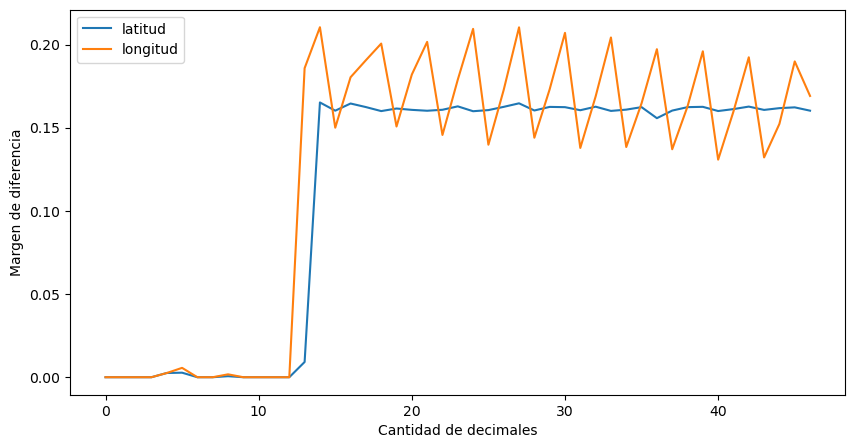

In [16]:
# Lo graficamos
plt.figure(figsize=(10,5))
plt.plot(lat_decimal_diff, label='latitud')
plt.plot(lon_decimal_diff, label='longitud')
plt.ylabel('Margen de diferencia')
plt.xlabel('Cantidad de decimales')
plt.legend()


In [17]:
geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))
geo_location_data_gdf.head()

,geonames_id,lat-lon,lat,lon,lat_alt,lon_alt,geometry
0,3430787.0,"-34.6618237,-58.5088387",-34.661824,-58.508839,-34.661824,-58.508839,POINT (-58.50884 -34.66182)
1,3432039.0,"-34.9038831,-57.9643295",-34.903883,-57.964330,-34.903883,-57.964329,POINT (-57.96433 -34.90388)
2,3430787.0,"-34.6522615,-58.5229825",-34.652262,-58.522982,-34.652262,-58.522982,POINT (-58.52298 -34.65226)
3,3431333.0,"-34.6477969,-58.5164244",-34.647797,-58.516424,-34.647797,-58.516424,POINT (-58.51642 -34.64780)
4,3435548.0,"-38.0026256,-57.5494468",-38.002626,-57.549447,-38.002626,-57.549447,POINT (-57.54945 -38.00263)



> Como se puede ver, las diferencias entre lat-lon y lat y lon comienzan a partir de los 13 decimales por lo que podemos descartarla como > una diferencia significativa.
> 
> Por otro lado, también hemos comprobado que los valores de lat lon provienen de convertir la variable a geometry y obtener de ahí lat y lon
>
> Entonces podemos concluir que la variable lat-lon es redundante y podemos eliminarla.
> ____ 

### Ver si hay outliers en lat y lon y su ubicación

<AxesSubplot:>

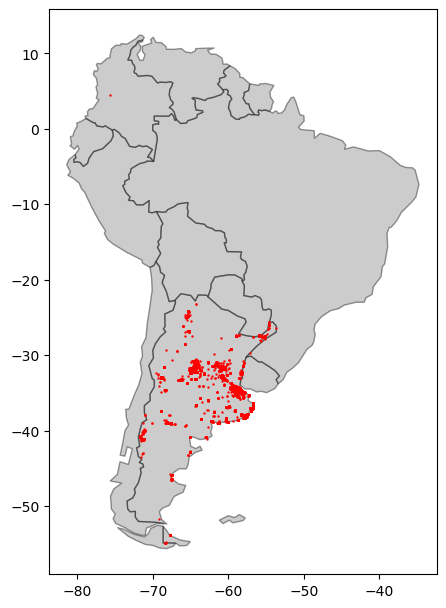

In [18]:
# convertimos el dataframe a geodataframe
geo_location_data_gdf = gpd.GeoDataFrame(geo_location_data, geometry=gpd.points_from_xy(geo_location_data.lon, geo_location_data.lat))

# Ubicamos los puntos en el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
latin_america = world[world['continent'] == 'South America']
fig, ax = plt.subplots(figsize=(5,10))
latin_america.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
geo_location_data_gdf.plot(ax=ax, markersize=0.5, color='red')

In [19]:
# Existe una propiedad que se encuentra fuera de la Argentina (en Colombia). 
# La buscamos en el dataframe original
# buscamos el polígono de Colombia
geo_colombia = world[world['name'] == 'Colombia']

# Buscamos la propiedad que se encuentra en Colombia
geo_outlier_index = geo_location_data_gdf[geo_location_data_gdf.within(geo_colombia['geometry'].iloc[0])].index

# La buscamos en el dataframe original
data.iloc[geo_outlier_index]


,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
9761,sell,house,Córdoba,|Argentina|Córdoba|,Argentina,Córdoba,3860255.0,"4.5458426,-75.67893099",4.545843,-75.678931,...,NaN,NaN,NaN,2.0,3.0,NaN,http://www.properati.com.ar/165i3_venta_casa_c...,Casa en Venta de 2 dorm. en Armenia,SE VENDE CASA EN EL BARRIO EL LIMONAR,https://thumbs4.properati.com/2/2huBKPZv0RyWda...


Es una propiedad súper interesante, por latitud y longitud está en Colombia, pero por el nombre de la provincia está en Argentina, la descripción habla de Armenia y el título del el Barrio el Limonar.

En una rápida búsqueda por internet encontramos que la propiedad se encuentra en el barrio El Limonar de Armenia, Colombia.

La descartamos sin dudas.



### Revisemos cómo está armada la información de lat y lon

Vamos a buscar si hay muchos puntos iguales para refutar la hipótesis de que los se utilizó la misma ubicación para varias propiedades

In [20]:
# Primero veamos una visualización de los datos de Capital Federal para ver si parece haber una gran concentración 
# de propiedades en algún lugar específico o están dispersas por toda la ciudad.
geo_location_data_gdf_capital = geo_location_data_gdf[data['state_name']=='Capital Federal']
geo_location_data_gdf_capital['geometry']

c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\geopandas\geodataframe.py:1428: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


0         POINT (-58.50884 -34.66182)
2         POINT (-58.52298 -34.65226)
3         POINT (-58.51642 -34.64780)
7         POINT (-58.44336 -34.55987)
8         POINT (-58.44336 -34.55987)
                     ...             
121153    POINT (-58.40252 -34.59921)
121158    POINT (-58.39737 -34.58743)
121160    POINT (-58.44268 -34.56369)
121209    POINT (-58.44268 -34.56369)
121217    POINT (-58.47560 -34.57064)
Name: geometry, Length: 23770, dtype: geometry

In [21]:
# Ubicamos los puntos en el mapa
df_barrios_capital = pd.read_csv('./barrios.csv', sep=',', encoding='latin-1')
import shapely.wkt

df_barrios_capital["WKT"] = df_barrios_capital["WKT"].apply(shapely.wkt.loads) 
df_barrios_capital = gpd.GeoDataFrame(df_barrios_capital, geometry='WKT')


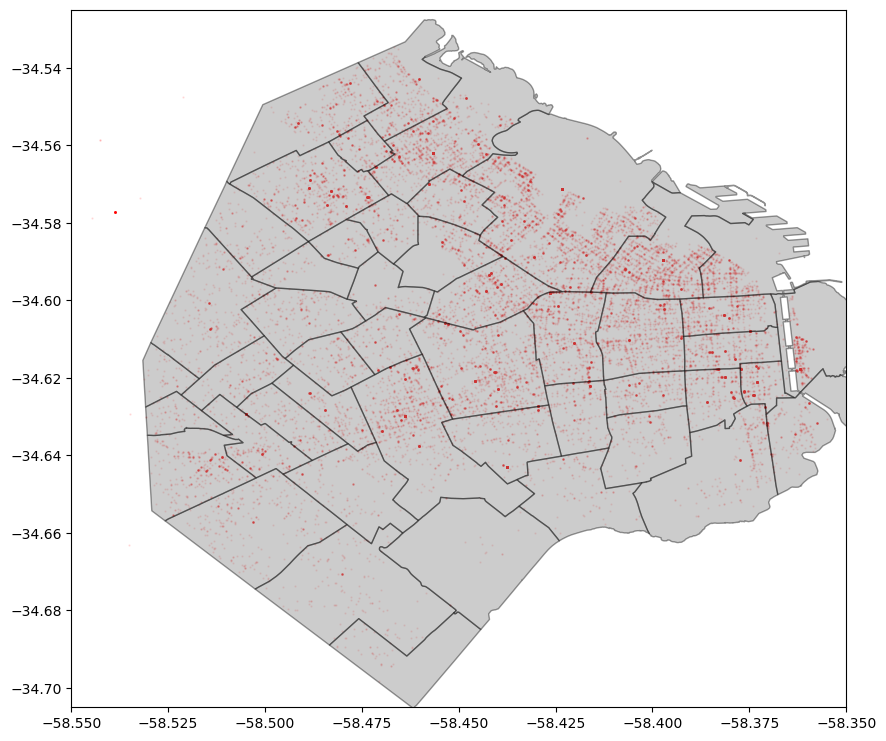

In [22]:
geo_location_data_gdf_capital['geometry']
fig, ax = plt.subplots(figsize=(10,20))

geo_location_data_gdf_capital.plot(ax=ax, markersize=0.5, color='red', alpha=0.1) 
df_barrios_capital.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.xlim(-58.55,-58.350)
plt.ylim(-34.705,-34.525) 
plt.show()

Cantidad de propiedades por punto: POINT (-58.66848 -34.40264)    312
POINT (-58.64985 -34.40014)    271
POINT (-58.43766 -34.64287)    259
POINT (-58.57966 -34.42509)    224
POINT (-58.39736 -34.58955)    156
                              ... 
POINT (-64.16211 -31.40195)      1
POINT (-64.18766 -31.42778)      1
POINT (-64.18595 -31.41274)      1
POINT (-64.17189 -31.41249)      1
POINT (-58.46064 -34.62950)      1
Name: geometry, Length: 47203, dtype: int64


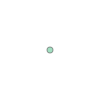

In [23]:
# Ahora veamos en todo el dataset cuántas propiedades comparten la misma ubicación.
different_locations = geo_location_data_gdf['geometry'].value_counts()
print('Cantidad de propiedades por punto:', different_locations) 
different_locations.index[0]

In [24]:
prop_qty_per_point = []
for i in range(1,different_locations[0]+1):
    (different_locations == i).sum() / different_locations.shape[0] * 100
    prop_qty_per_point.append((different_locations == i).sum() / different_locations.shape[0] * 100)
prop_qty_per_point = pd.DataFrame(prop_qty_per_point, columns=['Porcentaje'], index=range(1,different_locations[0]+1))
prop_qty_per_point.reset_index(inplace=True)
prop_qty_per_point.rename(columns={'index':'Cantidad de propiedades por punto'}, inplace=True)
prop_qty_per_point.head(10)

,Cantidad de propiedades por punto,Porcentaje
0,1,85.651336
1,2,8.353283
2,3,2.313412
3,4,1.091032
4,5,0.548694
5,6,0.449124
6,7,0.245747
7,8,0.213969
8,9,0.144059
9,10,0.161007


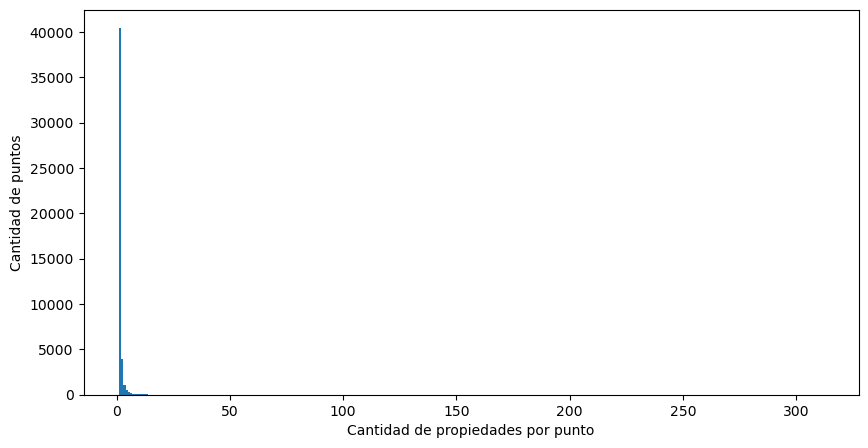

In [25]:
# Lo graficamos
plt.figure(figsize=(10,5))
plt.hist(different_locations, bins=different_locations[0]+1)
plt.ylabel('Cantidad de puntos')
plt.xlabel('Cantidad de propiedades por punto')
plt.show()



Veamos dónde se encuentran las propiedades que más tienen lat y lon iguales

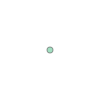

In [26]:
different_locations.index[0]

In [27]:
most_shared_point_props = geo_location_data_gdf[geo_location_data_gdf['geometry'].isin(different_locations.index[0:11])]
 

<AxesSubplot:>

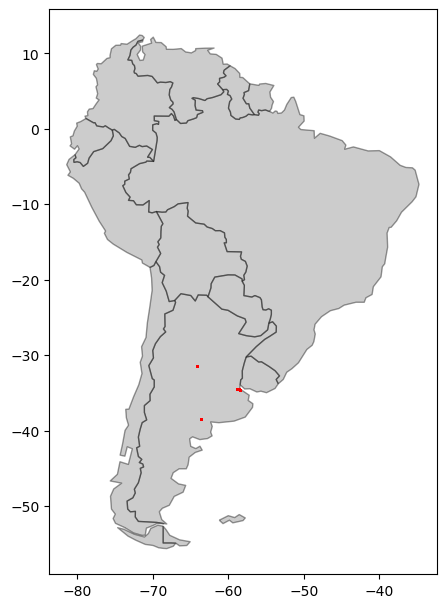

In [28]:
fig, ax = plt.subplots(figsize=(5,10))
latin_america.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
most_shared_point_props.plot(ax=ax, markersize=0.5, color='red')

In [41]:
# Parece que están todas en la Argentinta
# Descargamos un mapa de la Argentina por municipios para averiguar qué municipios son los que tienen más propiedades en el mismo punto.
# https://www.ign.gob.ar/NuestrasActividades/InformacionGeoespacial/CapasSIG
municipios_geo = gpd.read_file('./data/municipio/municipio.shp')
municipios_geo.head()

,gid,objeto,fna,gna,nam,in1,fdc,sag,geometry
0,470,Municipio,Municipio Loreto,Municipio,Loreto,540077,Ministerio de Ecología,IGN,"POLYGON ((-55.44698 -27.39184, -55.44724 -27.3..."
1,730,Municipio,Comuna Angeloni,Comuna,Angeloni,823862,Servicio de Catastro e Información Territorial,IGN,"POLYGON ((-60.67225 -30.74442, -60.67913 -30.7..."
2,99,Municipio,Municipio Campana,Municipio,Campana,060126,ARBA - Gerencia de Servicios Catastrales,IGN,"POLYGON ((-58.74946 -33.95459, -58.74735 -33.9..."
3,33,Municipio,Municipio El Huecú,Municipio,El Huecú,580182,Direc. Pcial. de Catastro e Inf. Territorial,IGN,"POLYGON ((-70.54255 -37.65973, -70.54988 -37.6..."
4,939,Municipio,Municipio Calilegua,Municipio,Calilegua,380126,Direc. Grl. de Catastro,IGN,"POLYGON ((-64.85258 -23.62648, -64.84967 -23.6..."


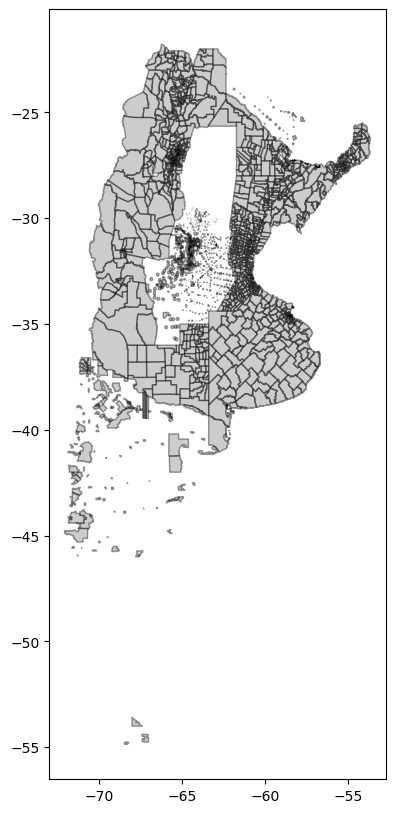

In [42]:
fig, ax = plt.subplots(figsize=(5,10))
municipios_geo.plot(ax=ax, alpha=0.4, color='grey', edgecolor='black')
plt.show()

In [46]:
# Veamos en qué municipios están las propiedades que comparten el mismo punto.
# convertimos a coordenadas geográficas para poder hacer el join con el geodataframe de las propiedades.
most_shared_point_props.crs = "EPSG:4326"
most_shared_point_props['geometry'] = most_shared_point_props['geometry'].to_crs(epsg=4326) 

c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
# Hacemos el join con el geodataframe de los municipios.
most_shared_point_props_municipios = gpd.sjoin(most_shared_point_props, municipios_geo, how="inner", op='intersects')
most_shared_point_props_municipios.head()

c:\Users\LuisD\anaconda3\envs\dh\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,geonames_id,lat-lon,lat,lon,lat_alt,lon_alt,geometry,index_right,gid,objeto,fna,gna,nam,in1,fdc,sag
18,3427753.0,"-34.425087,-58.5796585",-34.425087,-58.579659,-34.425087,-58.579659,POINT (-58.57966 -34.42509),118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
574,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,-34.400140,-58.649850,POINT (-58.64985 -34.40014),118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
577,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,-34.400140,-58.649850,POINT (-58.64985 -34.40014),118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
585,NaN,"-34.40014,-58.64985",-34.400140,-58.649850,-34.400140,-58.649850,POINT (-58.64985 -34.40014),118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN
591,3427753.0,"-34.425087,-58.5796585",-34.425087,-58.579659,-34.425087,-58.579659,POINT (-58.57966 -34.42509),118,90,Municipio,Municipio Tigre,Municipio,Tigre,060805,ARBA - Gerencia de Servicios Catastrales,IGN


In [50]:
most_shared_point_props_municipios['fna'].value_counts()

Municipio Tigre                 922
Comuna 7                        259
Comuna 2                        156
Comuna 14                       142
Municipio Córdoba               132
Comuna 13                       116
Municipio General San Martín    109
Municipio Pilar                 106
Name: fna, dtype: int64

> Podemos concluir que la gran mayoría de los puntos de lat y lon son únicos, por lo que descartamos que sean aproximaciones.
>  
> Una excepción notable son Tigre y Capital Federal
> 
> ____